In [34]:
import os
import sys

sys.path.insert(0, '../')

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = (18.0, 10.0)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from src.models.model_common import select_features
from src.models.train_model import generate_test_train_split

In [36]:
train_data = pd.read_hdf('../data/processed/train_3600000000000.hd5', 'data', parse_dates=[1])

In [37]:
site_data = train_data.loc[train_data['SiteId'] == 2, :]
site_data.head()

,ForecastId,Timestamp,obs_id,SiteId,Value,Frequency,DayOfMonth,DayOfWeek,DayOfYear,DaysInMonth,...,ConsumptionWeeklyMeanPerSurfaceArea,ConsumptionWeeklyMeanPerTemperatureDiff,ConsumptionBiWeeklyMeanPerSurfaceArea,ConsumptionBiWeeklyMeanPerTemperatureDiff,ConsumptionMonthlyMeanPerSurfaceArea,ConsumptionMonthlyMeanPerTemperatureDiff,ConsumptionHalfDayMeanPerSurfaceArea,ConsumptionHalfDayMeanPerTemperatureDiff,ConsumptionQuarterDayMeanPerSurfaceArea,ConsumptionQuarterDayMeanPerTemperatureDiff
0,5,2013-01-01 01:00:00,4382312,2,30159.963708,3.600000e+12,1,1,1,31,...,8.41742,158.431381,12.164211,228.952918,13.724307,258.316812,6.593402,124.100006,5.020022,94.48608
1,5,2013-01-01 02:00:00,2016541,2,29793.536720,3.600000e+12,1,1,1,31,...,8.41742,158.431381,12.164211,228.952918,13.724307,258.316812,6.593402,124.100006,5.020022,94.48608
2,5,2013-01-01 03:00:00,78869,2,31682.412161,3.600000e+12,1,1,1,31,...,8.41742,158.431381,12.164211,228.952918,13.724307,258.316812,6.593402,124.100006,5.020022,94.48608
3,5,2013-01-01 04:00:00,1361014,2,29881.829185,3.600000e+12,1,1,1,31,...,8.41742,158.431381,12.164211,228.952918,13.724307,258.316812,6.593402,124.100006,5.020022,94.48608
4,5,2013-01-01 05:00:00,129169,2,30560.328940,3.600000e+12,1,1,1,31,...,8.41742,158.431381,12.164211,228.952918,13.724307,258.316812,6.593402,124.100006,5.020022,94.48608


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a85f4be48>,
      dtype=object)

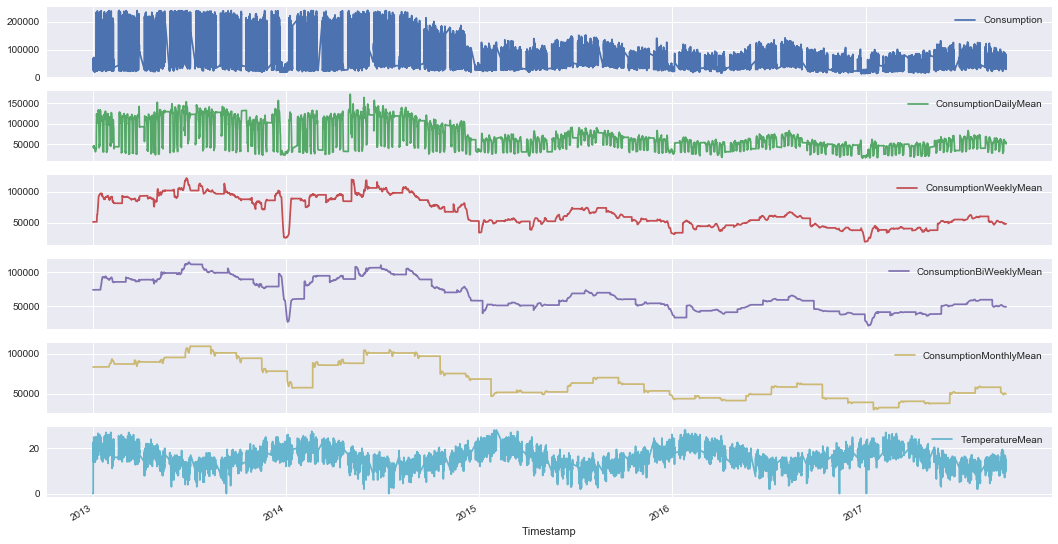

In [38]:
site_data.set_index('Timestamp')[['Consumption', 'ConsumptionDailyMean', 'ConsumptionWeeklyMean','ConsumptionBiWeeklyMean','ConsumptionMonthlyMean', 'TemperatureMean']].plot(subplots=True)

In [39]:
x, y, groups, ts = select_features(site_data, 'h')

In [40]:
x_train, y_train, g_train, ts_train, x_test, y_test, g_test, ts_test = \
    generate_test_train_split(x, y, groups, ts, 192)

from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler(quantile_range=(0.25, 0.75))

regressor = XGBRegressor()

# regressor.fit(x_train, scaler.fit_transform(y_train.reshape(-1, 1)))

In [62]:
from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(regressor, {
    'learning_rate': [0.11],
    'max_depth': [5],
    'n_estimators': [50],
    'colsample_bytree': [0.8],
    'colsample_bylevel': [0.7],
    'gamma': [0],
    'reg_alpha': [1, 1.1, 1.2],
    'reg_lambda': [1.1, 1.2, 1.3]
}, n_jobs=8, cv=8, scoring='neg_mean_squared_error')

gs.fit(x, y)

GridSearchCV(cv=8, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'learning_rate': [0.11], 'max_depth': [5], 'n_estimators': [50], 'colsample_bytree': [0.8], 'colsample_bylevel': [0.7], 'gamma': [0], 'reg_alpha': [1, 1.1, 1.2], 'reg_lambda': [1.1, 1.2, 1.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [63]:
gs.best_params_

{'colsample_bylevel': 0.7,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.11,
 'max_depth': 5,
 'n_estimators': 50,
 'reg_alpha': 1.1,
 'reg_lambda': 1.2}

In [15]:
gs.best_score_

-1771468491.065048